# M - M/(M + 2r/M) Sphere attraction - 

### Interacting spheres, go shell by shell.
## In this file I make 'dirt planets' with grav field energy outside them. This does not change the results from 'SphereAttractionViaShells.ipynb' 

The mass formula m(r) = M - M/(M + 2r/M) is from my paper 'Einstein's missing energy' 

The total mass of each object is M, the mass inside r is given by the formula. All the mass is not in the central object, as the mass energy of spacetime is taken into account, and thus one only measures the true mass of the object + spacetime as r >> m. 

The deviation from Newtonian and regular 'curved space has no energy' spacetime is tiny, and i don't think measurable on the solar system (which is a highly studied system). For instance the difference acceleration between Jupiter and Venus due to the sun is 3x10-8 from expected (if i did the math right). The force formula is calcGuessForce 

```
def calcGuessForce(d, m1, m2):
    # half way between using the masses at the halfway point Birkhoff style and full Newtonian mass
    r1 = d/2.0
    r2 = d - r1
    m1Inside = m1 - m1/(1 + 2*r1/m1)
    m2Inside = m2 - m2/(1 + 2*r2/m2)
    force = (m1Inside*m2Inside/(d*d) + m1*m2/(d*d))/2.0
    return force
```




In [84]:
import numpy as np
import time
import matplotlib
import matplotlib.pyplot as plt
%load_ext Cython 




The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


# Shell method:
For each shell on m1, go over all shells on m2, and add up forces
Force is sum over sum of (mS1*mS2/d**2)*overlap factor

Overlap factor is 1 if shells do not overlap (ie use shell theorem of Newton)
Overlap factor goes to zero if shells perfectly overlap, or one shell is inside the other. (Shell theorem)
Overlap factor goes smoothly otherwise.


In [85]:
%%cython
import numpy as np
import time
cimport cython
cimport numpy as cnp
cnp.import_array()

from libc.math cimport sqrt
from libc.math cimport fabs


cdef double massOfShell(double ri, double ro, double m):
    # i could improve accuracy by dropping the subtracted out 'm' - 
    # in other words calc mass outside ri and outside ro
    cdef double massInsideRi = m - m/(1 + 2*ri/m)
    cdef double massInsideRo = m - m/(1 + 2*ro/m)
    cdef double netMass = massInsideRo - massInsideRi
    return netMass

# cdef double cofMassOfShell(double ri, double ro, double m):
#     # not in middle, will be weighted towards r = 0
#     # dR/dM ratio * span
#     cdef double dMdRIn = (2.0*m*m)/((m + 2.0*ri)*(m + 2.0*ri))
#     cdef double dMdROut = (2.0*m*m)/((m + 2.0*ro)*(m + 2.0*ro))
#     cdef double ratio = dMdROut/dMdRIn # less than one
#     cdef double cofM = ri + ratio*(ro-ri)
#     return cofM

# planet radius is in terms of scwarzshild radius...
cdef double planetaryMassOfShell(double ri, double ro, double m, double planetRadius):
    # Get mass of shell of planetary matter (constant density) out to planetary radius, then 
    # after planetary radius simply return the normal 'black hole' one.
    # if ro > planetRadius:
    #     print("What are you doin", ri, ro, planetRadius)

    # if ri > planetRadius:
    #     # we want to adjust the planetRadius
    #     return massOfShell( ri, ro, m)
    

    # we are inside the planet. Assuming all the mass is inside the planet is a little wrong, but we will live with it for now.
    # in other words calc mass outside ri and outside ro
    cdef double planetVolume = 4.0/3.0*np.pi*planetRadius*planetRadius*planetRadius
    cdef double planetDensity = m/planetVolume

    # vol of shell - use subtraction hopefully wont numerically explode
    cdef outerVol = 4.0/3.0*np.pi*ro*ro*ro
    cdef innerVol = 4.0/3.0*np.pi*ri*ri*ri
    cdef volumeOfShell = outerVol - innerVol
    cdef double netMass = volumeOfShell*planetDensity
    # print("planet shell mass called:", netMass, ri, ro, m, planetRadius)  
    return netMass

# cdef double planetaryCenterOfMassOfShell(double ri, double ro, double m, double planetRadius):
#     # not in middle, will be weighted towards r = 0
#     # dR/dM ratio * span
#     if ro > planetRadius:
#         return cofMassOfShell( ri, ro, m)

#     return (ri + ro)/2.0 # is that close enough?


cpdef getShellForces(long numShells, double gridFine, double m1, double m2, double minDist, double maxDist, long dRes, planet1Radius, planet2Radius):
    cdef long planet1Shells = 0 # planet shells are 'inside planet shells' made of like dirt or gas
    cdef double fieldMassOutsidePlanet    
    if planet1Radius > 0:
        planet1Shells = 100
        fieldMassOutsidePlanet = m1/(1 + 2*planet1Radius/m1)
        massInPlanet1 = m1 - fieldMassOutsidePlanet
    
    cdef long planet2Shells = 0
    if planet2Radius > 0:
        planet2Shells = 100
        fieldMassOutsidePlanet = m2/(1 + 2*planet2Radius/m2)
        massInPlanet2 = m2 - fieldMassOutsidePlanet

    #silly consistency check - we need shells, usually call with 2000+
    if numShells < (planet1Shells + planet2Shells)*2:
        numShells = (planet1Shells + planet2Shells)*2

        

    #create shells: Each set of shells goes to r = ~inf - ok r --> big. 
    #don't spread shells out evenly, they get bigger delR as r goes up. 
    cdef cnp.ndarray[double] s1m = np.empty(numShells, dtype=np.double)
    cdef cnp.ndarray[double] s1r = np.empty(numShells, dtype=np.double)
    cdef cnp.ndarray[double] s1dr = np.empty(numShells, dtype=np.double)
    cdef cnp.ndarray[double] s1rout = np.empty(numShells, dtype=np.double)

    cdef cnp.ndarray[double] s2m = np.empty(numShells, dtype=np.double)
    cdef cnp.ndarray[double] s2r = np.empty(numShells, dtype=np.double)
    cdef cnp.ndarray[double] s2dr = np.empty(numShells, dtype=np.double)
    cdef cnp.ndarray[double] s2rout = np.empty(numShells, dtype=np.double)
    cdef long n
    # https://www.wolframalpha.com/input?i=derivative+of+M+-+M%2F%281+%2B+2x%2FM%29+
    # so dm(r)/dr = 2*M^2/(M + 2*r)^2
    # a shell at r weighs delR*dm/dr
    #spread the shells out in r, put r at middle of shell, 0 - dr

    cdef double r1in = 0, r2in = 0
    cdef double r1out = 0, r2out = 0
    cdef double delR1, delR2
    cdef double dM1, dM2
    cdef double totalM1 = 0
    cdef double totalM2 = 0
    for n in range(numShells):
        if n < planet1Shells:
            delR = planet1Radius/planet1Shells
            shellMass = planetaryMassOfShell(r1in, r1in + delR, massInPlanet1, planet1Radius)
        else:
            delR = (n*n + 1/2)*gridFine*m1
            shellMass = massOfShell(r1in, r1in + delR, m1)

        s1dr[n] = delR
        s1rout[n] = r1in + delR
        r1in = s1rout[n]
        s1m[n] = shellMass
        totalM1 += shellMass
    
        if n < planet2Shells:
            delR = planet2Radius/planet2Shells
            shellMass = planetaryMassOfShell(r2in, r2in + delR, massInPlanet2, planet2Radius)
        else:
            delR = (n*n + 1/2)*gridFine*m2
            shellMass = massOfShell(r2in, r2in + delR, m2)

        s2dr[n] = delR
        s2rout[n] = r2in + delR
        r2in = s2rout[n]
        s2m[n] = shellMass
        totalM2 += shellMass

    print("m1 asked vs obtained:", m1, totalM1)  
    m1 = totalM1
    print("m2 asked vs obtained:", m2, totalM2)
    m2 = totalM2
    print("furthest Shells:", s1rout[-1], s2rout[-1])  
    print("Furthest distance:", maxDist)  
    print("Range ratio needs to be way less than 1:", maxDist/max(s1rout[-1], s2rout[-1]))  
    # print("shell masses:", s1m)  
    # print("shell radii:", s1r)  
    # print("shell thicknesses:", s1dr)  
    # print("shell masses:", s2m)  
    # print("shell radii:", s2r)  
    # print("shell thicknesses:", s2dr)  

    # OK, lets calculate the forces for each distance
    distances = np.linspace(minDist, maxDist, dRes)
    cdef cnp.ndarray[double] forces = cnp.ndarray(dRes, dtype=np.double)
    cdef double d, forceSum, dm1, r1, dR1, shellForce, dSq, overlapFactor, dm2, r2, dR2
    cdef long dIndex = 0
    cdef long numShells2 = numShells
    cdef double dMax, dMin
    for d in distances:
        forceSum = 0 # total force at this distance
        # for each shell in m1, add up forces from all shells in m2
        dSq = d*d
        for n1 in range(numShells):
            dm1 = s1m[n1]
            r1 = s1r[n1]
            dR1 = s1dr[n1]
            r1out = s1rout[n1]
            for n2 in range(numShells2):
                overlapFactor = 1.0 # one means no overlap
                #if shells overlap, force drops with overlap factor
                r2 = s2r[n2]
                dm2 = s2m[n2]
                dR2 = s2dr[n2]
                r2out = s2rout[n2]
                # for overlap to occur: outer edges must touch
                if r1out + r2out > d:
                    r1in = r1out - dR1
                    r2in = r2out - dR2
                    #if r1in > (d + r2out) or r2in > (d + r1out):
                    if d < fabs(r1in - r2in):
                        overlapFactor = 0 # one shell is entirely inside the other...
                    else:
                        # use a linear approximation - force drops linearly across shell, see ShellAttractionCython
                        #overlapFactor is 1 at  r1out + r2out = d
                        #overlapFactor is 0 at  fabs(r1in - r2in) = d
                        dMax = r1out + r2out
                        dMin = fabs(r1in - r2in)
                        overlapFactor = (d - dMin)/(dMax - dMin)
                shellForce = overlapFactor*dm1*dm2/dSq
                forceSum += shellForce
        forces[dIndex] = forceSum
        dIndex += 1

    return distances, forces


In [86]:
#my formula for mass inside of d/2
def calcBirkhoff(d, m1, m2):
    r1 = d*m1/(m2 + m1)
    r2 = d - r1
    m1Inside = m1 - m1/(1 + 2*r1/m1)
    m2Inside = m2 - m2/(1 + 2*r2/m2)
    force = m1Inside*m2Inside/(d*d)
    return force

def calcBirkhoffEqual(d, m1, m2):
    r1 = d/2.0
    r2 = d - r1
    m1Inside = m1 - m1/(1 + 2*r1/m1)
    m2Inside = m2 - m2/(1 + 2*r2/m2)
    force = m1Inside*m2Inside/(d*d)
    return force
    
def calcGuessForce(d, m1, m2):
    r1 = d/2.0
    r2 = d - r1
    m1Inside = m1 - m1/(1 + 2*r1/m1)
    m2Inside = m2 - m2/(1 + 2*r2/m2)
    force = (m1Inside*m2Inside/(d*d) + m1*m2/(d*d))/2.0
    return force


In [97]:

m1 = 1
m2 = 10
gridFine = 0.00003 # how fine to make the grid

#planetary masses. Set to zero to assume an almost black hole
# units are same as masses, so earth is 6300km/1cm 
planet1Radius = 0
planet2Radius = 2000*m2

# scale distances with mass for easier graphs
minDist = 1960*(m1 + m2)
maxDist = 10000*(m1 + m2)
dRes = 300


#calc with shells
start_time = time.time()
shellDistances, shellForces = getShellForces(6000, gridFine, m1, m2, minDist, maxDist, dRes, planet1Radius, planet2Radius)
print("getShellForces took:", (time.time() - start_time))
# print("forces at each dist, shell method: ", shellForces)




m1 asked vs obtained: 1.0 0.9999995998801561
m2 asked vs obtained: 10.0 9.999996005163721
furthest Shells: 1249625.0999999985 12516152.480000012
Furthest distance: 110000.0
Range ratio needs to be way less than 1: 0.00878864332915189
getShellForces took: 9.714062929153442


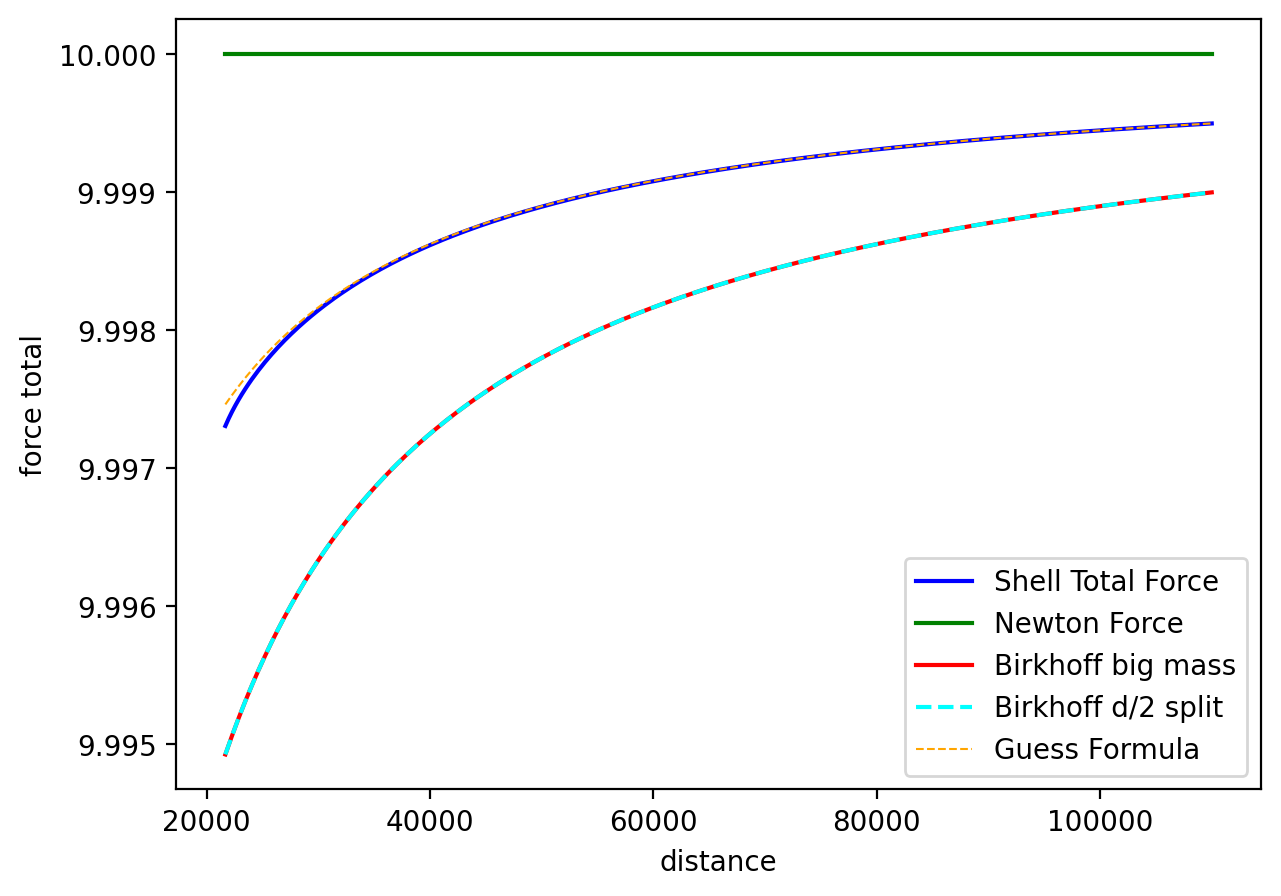

In [98]:

dCount = 0
shellTotalForces = []
shellNewtonTotalForce = []
shellBirkhoffTotalForce = []
shellBirkhoffEqualTotalForce = []
shellGuessTotalForce = []
for d in shellDistances:
    d2 = d*d
    dM = d2 # set to d2 to see errors from r^2, set dM to 1 to see actual r^2 graph
    #dM = 1 
    shellTotalForces.append(shellForces[dCount]*dM)
    shellNewtonTotalForce.append(m1*m2*dM/(d2))
    shellBirkhoffTotalForce.append(calcBirkhoff(d, m1, m2)*dM)
    shellBirkhoffEqualTotalForce.append(calcBirkhoffEqual(d, m1, m2)*dM)
    shellGuessTotalForce.append(calcGuessForce(d, m1, m2)*dM)
    dCount += 1

fig = plt.figure(figsize=(7, 5), dpi=200)
plt.plot(shellDistances, shellTotalForces, marker="none", color='blue', lw=1.5, label='Shell Total Force')
plt.plot(shellDistances, shellNewtonTotalForce, marker="none", color='green', lw=1.5, label='Newton Force')
plt.plot(shellDistances, shellBirkhoffTotalForce, marker="none", color='red', lw=1.5, label='Birkhoff big mass')
plt.plot(shellDistances, shellBirkhoffEqualTotalForce, marker="none", color='cyan', lw=1.5, label='Birkhoff d/2 split', linestyle='--' )
plt.plot(shellDistances, shellGuessTotalForce, marker="none", color='orange', lw=0.75, label='Guess Formula', linestyle='--' )
plt.xlabel('distance');
plt.ylabel('force total');
plt.legend(loc='lower right')
#plt.axis((0, maxDist, minForce*0.9, maxForce*1.1));
#plt.savefig('../chapters/images/force.png', bbox_inches='tight')
plt.show()



## Notes: 
# The Shell force is calculated with many (thousands) of shells of matter on each mass, laid out as per the M - M/(M + 2R/M) mass inside r formula. Shell interactions come in 3 varieties: 
- with the correct parameter choice you can see where the solid cores start to overlap, and the guess formula is wrong, as the guess formula is only for the vacuum solution.
- Shells non overlapping --> use shell theorem - Newton force
- One shell inside another --> use shell theorem - No force
- Shells overlapping - use a model (linear) to interpolate (see ShellAttractionCython file for how this works)

The Birkhoff force is calculated using only non overlapping portions - EG if two masses are d apart, then use the formula M - M/(M + 2(d/2)/M) for each mass to get the enclosed Birkhoff. I tried changing where the split is, no changes, as one can see by the graph, and setting m1 = (say) 10, m2 = 1, etc

# looks like the force is 1/2 way between the birkhoff calc and the Newton perfect 1/r**2 one. 
The guess formula is (birkoff + newton)/2

# NOTE: the graph is presented with dM = 1 meaning that deviations from 1/r^2 force are shown. 